<a href="https://colab.research.google.com/github/kavyajeetbora/EAST/blob/master/EAST_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##1. Imports

[**Tasks - Incidental Scene Text**](https://rrc.cvc.uab.es/?ch=4&com=tasks)

In [36]:
!pip install lanms

In [0]:
import os
from PIL import Image
from torch.utils.model_zoo import load_url
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
import lanms

In [38]:
%%time

!git clone -l -s git://github.com/kavyajeetbora/EAST.git cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 94 (delta 5), reused 0 (delta 0), pack-reused 82
Receiving objects: 100% (94/94), 2.07 MiB | 16.84 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/cloned-repo/cloned-repo
dataset.py  dsiplay_ground_truth.ipynb	EAST_text_detector.ipynb  model.py
detect.py   EAST_detection.ipynb	loss.py			  train.py
CPU times: user 70.5 ms, sys: 41.1 ms, total: 112 ms
Wall time: 4.13 s


In [39]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [40]:
from dataset import custom_dataset

# AI4Bharat dataset
image_address = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/15. Object Detection/Simple YOLO model/Data/Sample Images'
label_address = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/15. Object Detection/Simple YOLO model/Data/Sample Annotations'
model_path = '/content/drive/My Drive/Colab Notebooks/padh.ai.notebooks/15. Object Detection/EAST scene text detector/model_epoch_67.pth'

training_dataset = custom_dataset(image_address, label_address)
print(len(training_dataset))

428


## Detecting

In [41]:
from model import EAST
# set up the pretrained model
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = EAST().to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

EAST(
  (extractor): extractor(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=

120


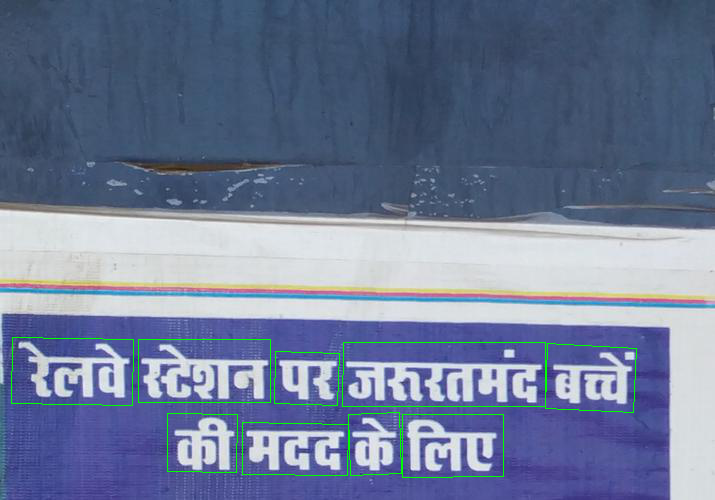

In [64]:
from detect import *
from model import EAST

## choose an random image
img_files = os.listdir(image_address)
index = np.random.choice(len(img_files))
image_path = os.path.join(image_address,img_files[index])

print(index)
img = Image.open(image_path)
boxes = detect(img, model, device)
plot_boxes(img, boxes)

## Test image from google

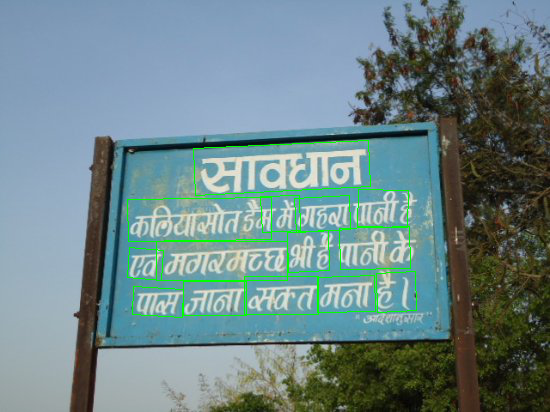

In [50]:
img = Image.open('/content/signboard.jpg')
boxes = detect(img, model, device)
plot_boxes(img, boxes)

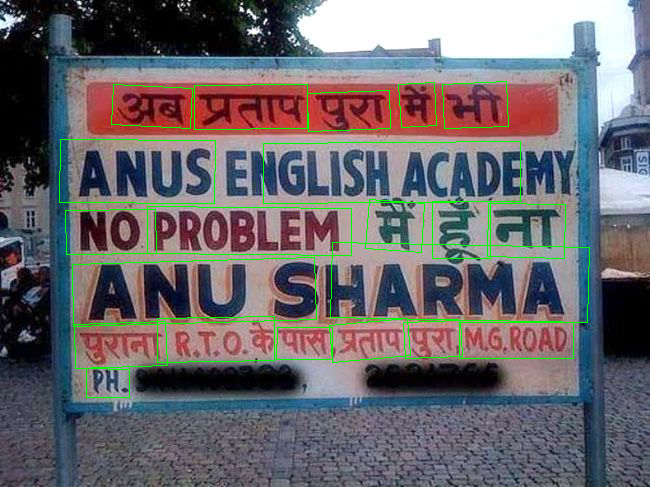

In [65]:
img = Image.open('/content/signboard2.jpg')
boxes = detect(img, model, device)
plot_boxes(img, boxes)